# 3D Vision Demo
In this notebook the methods of 3D vision are demonstrated

## Setup
### Install OpenCV

In [4]:
!pip install opencv-python

### Download Images

In [5]:
!wget http://deeplearning.iit.bme.hu/3DPractImgs.zip
!unzip -qq 3DPractImgs.zip
!rm 3DPractImgs.zip

--2020-05-04 18:05:09--  http://deeplearning.iit.bme.hu/3DPractImgs.zip
Resolving deeplearning.iit.bme.hu (deeplearning.iit.bme.hu)... 152.66.243.112
Connecting to deeplearning.iit.bme.hu (deeplearning.iit.bme.hu)|152.66.243.112|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 883881 (863K) [application/zip]
Saving to: ‘3DPractImgs.zip’

3DPractImgs.zip     100%[===================>] 863.17K   633KB/s    in 1.4s    

2020-05-04 18:05:12 (633 KB/s) - ‘3DPractImgs.zip’ saved [883881/883881]



## Camera Calibration

### Prepare point arrays

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(7,5,0)
objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:8,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpointsL = [] # 2d points in left image plane.
imgpointsR = [] # 2d points in right image plane.

### Detect Chessboard corners

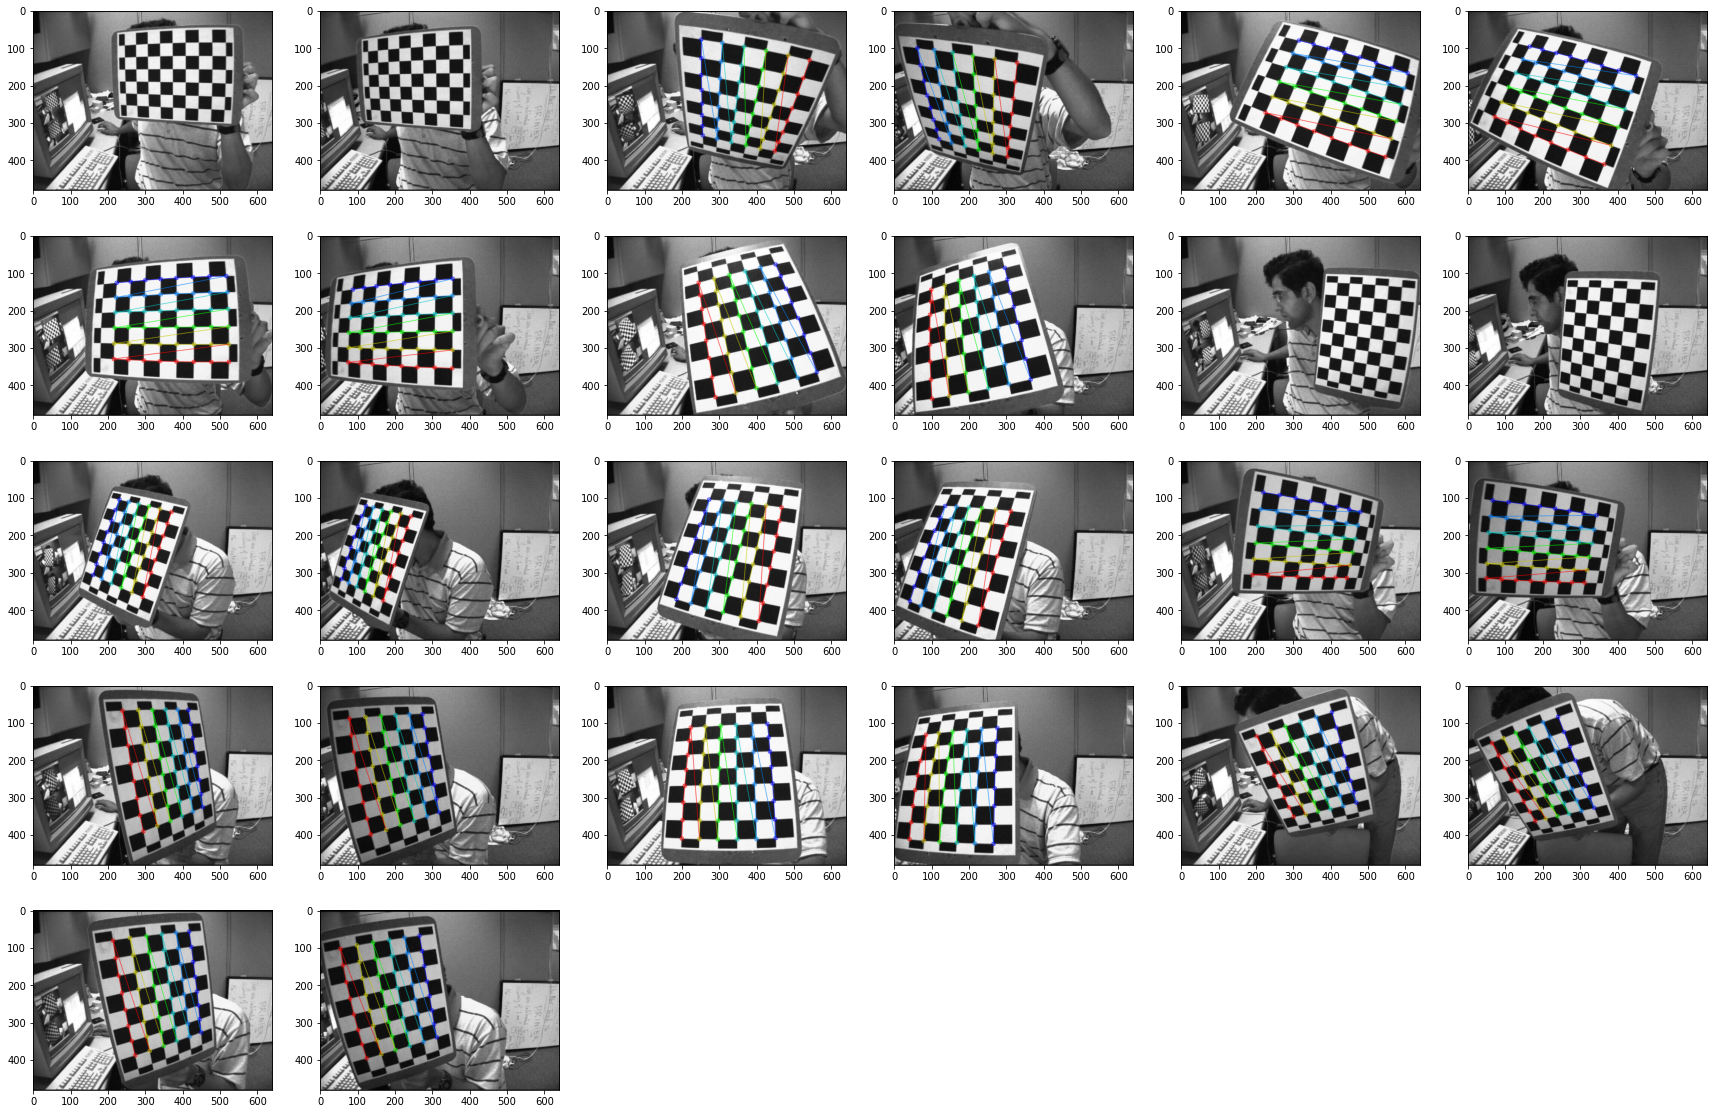

In [7]:
# Left and right images
imagesL = sorted(glob.glob('imgs/left*.jpg'))
imagesR = sorted(glob.glob('imgs/right*.jpg'))
        
plt.figure(figsize=(30,20))

for i,(fnameL,fnameR) in enumerate(zip(imagesL,imagesR)):
        
    # Read images
    imgL = cv2.imread(fnameL)
    imgR = cv2.imread(fnameR)
    
    # Grayscale
    grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
    
    # Find the chess board corners
    retL, cornersL = cv2.findChessboardCorners(grayL, (8,6), cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_NORMALIZE_IMAGE+cv2.CALIB_CB_FAST_CHECK)
    retR, cornersR = cv2.findChessboardCorners(grayR, (8,6), cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_NORMALIZE_IMAGE+cv2.CALIB_CB_FAST_CHECK)
    
    # If found
    if retL and retR:
        
        # Subpixel refinement
        corners2L = cv2.cornerSubPix(grayL,cornersL, (11,11), (-1,-1), (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
        corners2R = cv2.cornerSubPix(grayR,cornersR, (11,11), (-1,-1), (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
        
        # Add object and image points to the lists
        objpoints.append(objp)
        imgpointsL.append(corners2L)
        imgpointsR.append(corners2R)
        
        # Draw
        cv2.drawChessboardCorners(imgL, (8,6), corners2L, retL)
        cv2.drawChessboardCorners(imgR, (8,6), corners2R, retR)
        
   
    plt.subplot(5,6,2*i+1)
    plt.imshow(imgL)
    plt.subplot(5,6,2*i+2)
    plt.imshow(imgR)
        

### Calibrate

In [8]:
retL, AL, distL, rvecsL, tvecsL = cv2.calibrateCamera(objpoints, imgpointsL, grayL.shape[::-1], None, cv2.CALIB_ZERO_TANGENT_DIST)
retR, AR, distR, rvecsR, tvecsR = cv2.calibrateCamera(objpoints, imgpointsR, grayR.shape[::-1], None, cv2.CALIB_ZERO_TANGENT_DIST)
print(retL,retR)
print(AL)
print(AR)
print(distL)
print(distR)

0.1693996254377044 0.16913230250629366
[[533.00375604   0.         341.87679199]
 [  0.         533.02410527 234.64224374]
 [  0.           0.           1.        ]]
[[537.05214912   0.         326.90942077]
 [  0.         536.52172151 249.13482785]
 [  0.           0.           1.        ]]
[[-2.79873420e-01]
 [ 2.88848570e-02]
 [ 1.21786480e-03]
 [ 4.10045170e-05]
 [ 1.26967524e-01]]
[[-0.29675091]
 [ 0.15420348]
 [-0.00056645]
 [ 0.00067218]
 [-0.07629902]]


### Undistort

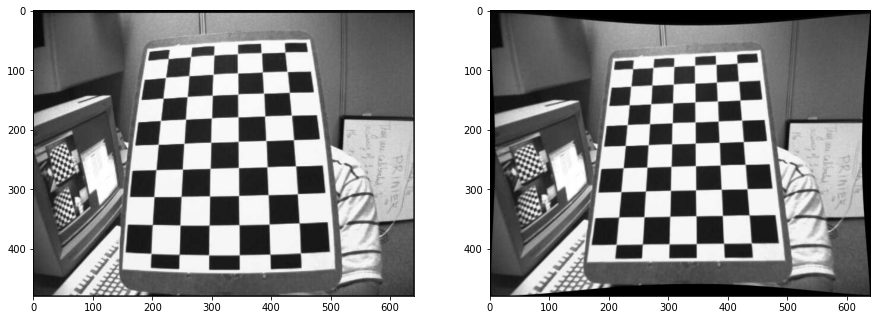

In [9]:
img = cv2.imread('imgs/left12.jpg')
h,  w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(AL, distL, (w,h), 1, (w,h))
dst = cv2.undistort(img, AL, distL, None, newcameramtx)
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(dst)

## Stereo Calibration
### Compute stereo calibration matrices

In [10]:
retS,_,_,_,_,R,T,E,F = cv2.stereoCalibrate(objpoints, imgpointsL, imgpointsR, AL, distL, AR, distR, (w,h))

print(retS)
print(R)
print(T)

0.18540003564847085
[[ 0.99998575  0.00376664  0.00378419]
 [-0.00374455  0.99997601 -0.0058269 ]
 [-0.00380605  0.00581264  0.99997586]]
[[-3.32538396e+00]
 [ 3.69636515e-02]
 [ 1.35166963e-03]]


### Compute Rectification transformation

In [0]:
RL,RR,PL,PR,Q,_,_ = cv2.stereoRectify(AL,distL,AR,distR,(w,h),R,T)

# Lookup table maps for rectification
mapL1,mapL2 = cv2.initUndistortRectifyMap(AL,distL,RL,PL,(w,h),cv2.CV_16SC2)
mapR1,mapR2 = cv2.initUndistortRectifyMap(AR,distR,RR,PR,(w,h),cv2.CV_16SC2)

### Apply rectification on the images

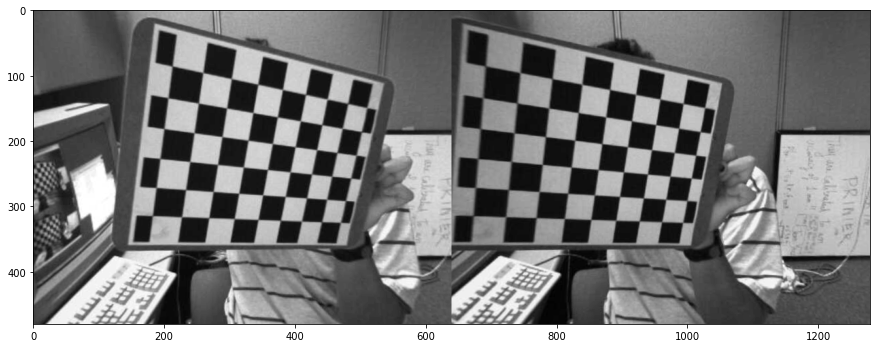

In [33]:
imgL = cv2.imread('imgs/left09.jpg')
imgR = cv2.imread('imgs/right09.jpg')

# Remap using Bilinear interpolation
uL = cv2.remap(imgL,mapL1,mapL2,cv2.INTER_LINEAR)
uR = cv2.remap(imgR,mapR1,mapR2,cv2.INTER_LINEAR)

uL = cv2.cvtColor(uL, cv2.COLOR_BGR2GRAY)
uR = cv2.cvtColor(uR, cv2.COLOR_BGR2GRAY)

# Put images side-by-side
und = np.concatenate((uL,uR),1)

plt.figure(figsize=(15,10))
plt.imshow(und, cmap='gray')

## Disparity Computation

In [0]:
# Read stereo pair
imgL = cv2.imread('imgs/tsukuba_l.png',0)
imgR = cv2.imread('imgs/tsukuba_r.png',0)

# Create BM and SGBM algorithms
stereo = cv2.StereoBM_create(numDisparities=256, blockSize=7)
stereo2 = cv2.StereoSGBM_create(numDisparities=256, blockSize=13,P1=100,P2=300, minDisparity=0)

# Compute disparities
disparity = stereo.compute(uL,uR)
disparity2 = stereo2.compute(uL,uR)

# Plot
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(imgL,'gray')
plt.subplot(1,3,2)
plt.imshow(disparity,'gray')
plt.subplot(1,3,3)
plt.imshow(disparity2,'gray')

### Reprojection

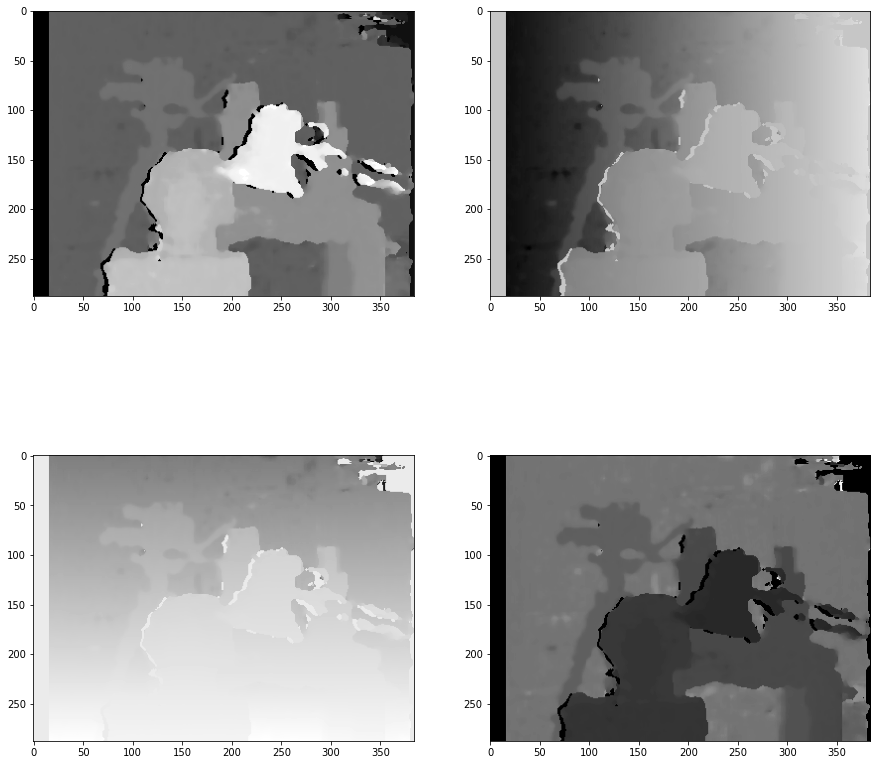

In [14]:
# Reproject
xyz = cv2.reprojectImageTo3D(disparity2,Q,handleMissingValues=True)

# Get X,Y,Z coordinates
xdata = xyz[...,0]
ydata = xyz[...,1]
zdata = xyz[...,2]

# Clean Outliers
xdata[zdata > 50] = 0
ydata[zdata > 50] = 0
zdata[zdata > 50] = 0

# 3D plotting
fig = plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.imshow(disparity2,'gray')
plt.subplot(2,2,2)
plt.imshow(xdata,'gray')
plt.subplot(2,2,3)
plt.imshow(ydata,'gray')
plt.subplot(2,2,4)
plt.imshow(zdata,'gray')

## k-Means Segmentation

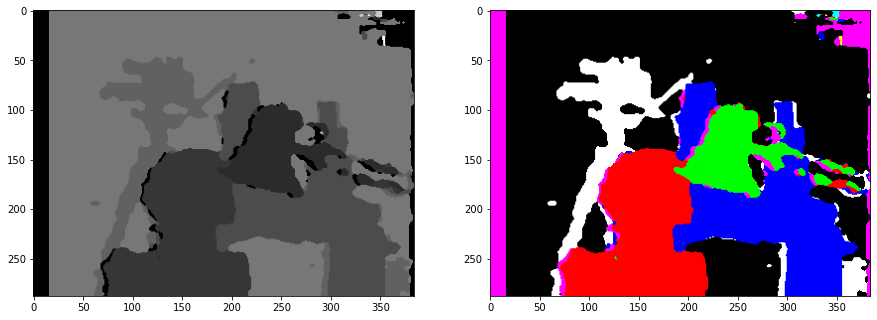

In [15]:
colors = np.array([[0, 0, 0],[255, 0, 0],[0, 255, 0],[0, 0, 255],
                   [255, 255, 0],[255, 0, 255],[0, 255, 255],[255, 255, 255],
                   [127, 127, 0],[127, 0, 127],[0, 127, 127],[127, 127, 127]
])

cv2.setRNGSeed(112)

# Do some filtering
filtered_Z = cv2.medianBlur(zdata, 3)

# Reshape
Z = filtered_Z.reshape((-1,1))

# convert to np.float32
Z = np.float32(Z)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
K = 8
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res = res.reshape((zdata.shape))

# Convert into color code
res2 = colors[label.flatten()]
res2 = res2.reshape((zdata.shape[0], zdata.shape[1], 3))

fig = plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(res,'gray')
plt.subplot(1,2,2)
plt.imshow(res2)

## Contour-based segmentation

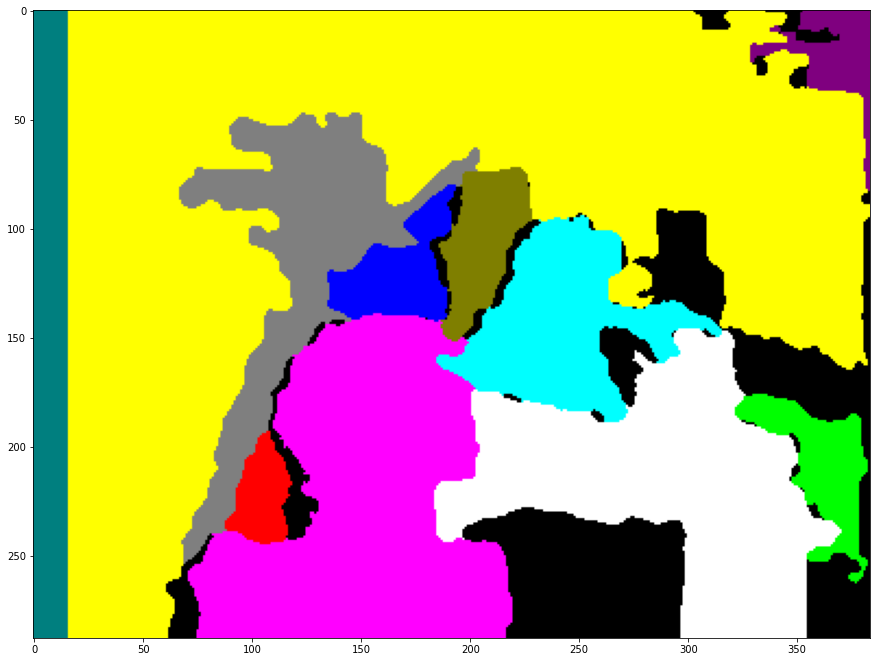

In [16]:
# Initialize image
finalRes = np.uint8(np.zeros_like(res2))
contIndex = 0

# For every cluster
for cent in center:

    # Mask image
    mask = np.uint8(res == cent)

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # For every contour
    for i, c in enumerate(contours):

        # Compute area
        a = cv2.contourArea(c)

        # Filter big ones
        if a > 800:
            # draw
            color = [int(colors[contIndex][0]), int(colors[contIndex][1]), int(colors[contIndex][2])]
            cv2.drawContours(finalRes, contours, i, color, -1)
            contIndex += 1

fig = plt.figure(figsize=(15,15))
plt.imshow(finalRes)